In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rtde_control, rtde_receive

ROBOT_HOST = "10.42.0.162" # IP address of the robot

rtde_r = rtde_receive.RTDEReceiveInterface(ROBOT_HOST)
rtde_c = rtde_control.RTDEControlInterface(ROBOT_HOST)


In [3]:
from tools.controller import *
controller = CalibrationController(rtde_r, rtde_c)

transform = np.array([[1, 0, 0],
                      [0, 0, -1],
                      [0, 1, 0]])
controller.set_transform(transform)

start_point = controller.get_sensor_pose()[0:3]

In [4]:
import time
from tools.measuring import MeasuringInterface
measuring_interface = MeasuringInterface(controller)

In [5]:
measuring_interface.start_measuring("tmp")

In [6]:
measuring_interface.stop_measuring()

In [33]:
# Top point
controller.move_absolute(start_point[0:3])
top_point_z = controller.find_contact_point([0, 0, -1], 0.005)[2] 
controller.move_absolute(start_point[0:3])

depth = top_point_z - start_point[2] - 0.008

# Double X points
controller.move_relative([0.02, 0.003, 0])
controller.move_relative([0.0, 0, depth], 0.01)
x_pose_1 = controller.find_contact_point([-1, 0, 0], 0.005)[0:2]
controller.move_relative([0.005, 0, 0])

controller.move_relative([0, -0.003 * 2, 0])
x_pose_2 = controller.find_contact_point([-1, 0, 0], 0.005)[0:2]
controller.move_relative([0.005, 0, -depth])
controller.move_absolute(start_point[0:3])

# Extra x point other side
controller.move_absolute(start_point[0:3])
controller.move_relative([-0.02, 0, 0])
controller.move_relative([0.0, 0, depth], 0.01)
x_pose_3 = controller.find_contact_point([1, 0, 0], 0.005)[0:2]
controller.move_relative([-0.005, 0, -depth])
controller.move_absolute(start_point[0:3])


# Single Y point
controller.move_relative([0, 0.02, 0])
controller.move_relative([0.0, 0, depth], 0.01)
y_pose_1 = controller.find_contact_point([0, -1, 0], 0.005)[0:2]
controller.move_relative([0, 0.005, -depth])
controller.move_absolute(start_point[0:3])

poses = np.array([x_pose_1, x_pose_2, x_pose_3, y_pose_1])

Width x: 0.024996057930444994, width y: 0


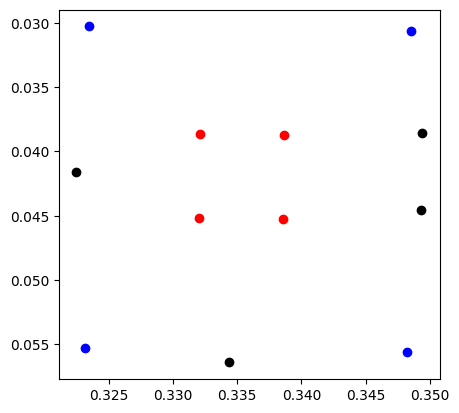

In [34]:
from tools.helpers import *
import matplotlib.pyplot as plt

tool_width = 0.002 / 2 # We want radius
pitch = 0.0065
offset = (0.0055 + pitch / 2, 0.007 + pitch / 2) # Offset should be the position of the first sensor, NOT the corner of the silicon
sensor_grid_size = (2, 2)
nr_of_subpoints = 0

grid_size = (sensor_grid_size[0] + (sensor_grid_size[0] - 1) * nr_of_subpoints, sensor_grid_size[1] + (sensor_grid_size[1] - 1) * nr_of_subpoints )

width_x = np.linalg.norm(np.array(x_pose_1) - np.array(x_pose_3)) - 2 * tool_width
# width_y = np.linalg.norm(np.array(y_pose_1) - np.array(y_pose_2)) - 2 * tool_width

print(f"Width x: {width_x}, width y: {0}")

corners, deltas = get_square_corners(x_pose_1, x_pose_2, y_pose_1, width_x, width_x, tool_width)

# Corners index 0 and 3 are the bottom points
# So now we need to calculate the grid based on those

plt.scatter(poses[:, 0], poses[:, 1], c='black')
plt.scatter(corners[:, 0], corners[:, 1], c='blue')

grid = calculate_grid_on_square(corners, offset, grid_size, pitch / (nr_of_subpoints + 1))

plt.scatter(grid[:, :, 0], grid[:, :, 1], c='red')
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()

In [35]:
# Check if ok
z_clearance = 0.0005
duration = 5

controller.move_absolute(start_point[0:3])

for row in grid:
    for point in row:
        
        # Move above point
        controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
        time.sleep(duration / (grid_size[0] * grid_size[1]))
  
controller.move_absolute(start_point[0:3])

[0.33439127661742923,
 0.04156527856287354,
 0.007625693420460393,
 2.20197698762667,
 -2.230243943155513,
 0.01805106231301463]

In [39]:
import time

rtde_c.zeroFtSensor()
name = "tmp"
# name = "2x2_grid_subsampling_x1_normal_probe_06032024"
measuring_interface.start_measuring(name)

time.sleep(3)

# Now push on every point in the grid to calibrate
z_clearance = 0.005
limits = [0.01, 0.01, 0.01]

normal_forces = -1 * np.arange(0, 10, 1)

controller.move_absolute(start_point[0:3])

for row in grid:
    for point in row:
        
        # Move above point
        controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
        controller.move_absolute([point[0], point[1], top_point_z], velocity=0.01)
        
        # Now apply normal forces
        for force in normal_forces:
            controller.force_mode([0, 0, 1], [0, 0, force], limits)
            time.sleep(0.5)
            
        controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=0.01)
        

rtde_c.forceModeStop()
controller.move_absolute(start_point[0:3])

time.sleep(3)
measuring_interface.stop_measuring()

Exception in thread Thread-17 (read_and_publish_sensor_sync):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lowiek/masters-thesis/notebooks/tools/sensor_reader.py", line 52, in read_and_publish_sensor_sync
    data = ser.read(1)
  File "/home/lowiek/.local/lib/python3.10/site-packages/serial/serialposix.py", line 595, in read
    raise SerialException(
serial.serialutil.SerialException: device reports readiness to read but returned no data (device disconnected or multiple access on port?)


In [43]:
# XY measurements (by slipping the probe)

rtde_c.zeroFtSensor()

name = "2x2_grid_xy_probe_06032024"
measuring_interface.start_measuring(name)

time.sleep(3)

# Now push on every point in the grid to calibrate
z_clearance = 0.005
limits = [0.01, 0.01, 0.01]

# (normal force, side force)
forces = np.array([[1, 10], [2, 10], [5, 10], [10, 10]])

controller.move_absolute(start_point[0:3])

for force in forces:
    
    normal_force, side_force = force
                    
    for reversed in [False, True]:

        selection_vector = [1, 0, 1]
        wrench = [-abs(side_force) if reversed else abs(side_force), 0, -normal_force] 
        for row in grid:
            
            # Start from first point in grid (which is always most +x)
            point = row[-1 if reversed else 0]
            
            # Move to start point
            controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
            controller.move_absolute([point[0], point[1], top_point_z], velocity=0.01)
            
            time.sleep(0.5)
            
            # Apply force until meeting next point
            next_point = row[0 if reversed else -1]
            controller.force_mode(selection_vector, wrench, limits)
            
            # Move to last point in row
            distance = 9999
            while distance > 0.0005:
                distance = np.linalg.norm(np.array(controller.get_sensor_pose()[0:2]) - np.array(next_point))
            rtde_c.forceModeStop()
            
            time.sleep(0.5)
            
            # Move back to safety        
            controller.move_relative([0, 0, z_clearance], velocity=0.01)
            
        # Do the same with columns
        selection_vector = [0, 1, 1]
        wrench = [0, abs(side_force) if reversed else -abs(side_force), -normal_force] 
        for col in grid.transpose((1,0,2)):
            
            # Start from first point in grid (which is always most +x)
            point = col[-1 if reversed else 0]
            
            # Move to start point
            controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
            controller.move_absolute([point[0], point[1], top_point_z], velocity=0.01)
            
            time.sleep(0.5)
            
            # Apply force
            next_point = col[0 if reversed else -1]
            controller.force_mode(selection_vector, wrench, limits)
            
            # Move to last point in column
            distance = 9999
            while distance > 0.0005:
                distance = np.linalg.norm(np.array(controller.get_sensor_pose()[0:2]) - np.array(next_point))
            rtde_c.forceModeStop()
            
            time.sleep(0.5)
            
            # Move back to safety        
            controller.move_relative([0, 0, z_clearance], velocity=0.01)

rtde_c.forceModeStop()
controller.move_absolute(start_point[0:3])

time.sleep(3)
measuring_interface.stop_measuring()

In [44]:
measuring_interface.stop_measuring()
rtde_c.stopScript()

In [37]:
measuring_interface.stop_measuring()

In [23]:
controller.move_absolute(start_point[0:3])

[0.3343631234419601,
 0.04155160925808435,
 0.007622315731274895,
 2.20217989952456,
 -2.2323723347687148,
 0.02088859815443381]